#### Выгрузка данных и первичный анализ

In [86]:
from dotenv import load_dotenv
import os
import requests as rq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:
load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

current_dir = os.getcwd() 
charts_folder = os.path.join(current_dir, 'charts')

if not os.path.exists(charts_folder):
    os.makedirs(charts_folder)

v = rq.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})
r = rq.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})

visits = pd.DataFrame(v.json())
regs = pd.DataFrame(r.json())

# Конверсия

#### Очистка и объединение данных визитов и регистраций по дате и платформе

In [113]:
def visits_ag(visits):
    visits = visits.sort_values('datetime').groupby('visit_id').tail(1)
    visits['date_group'] = pd.to_datetime(visits['datetime']).dt.date
    visits_agr = visits.drop(['datetime', 'user_agent'], axis=1)
    visits_agr = visits_agr.groupby(['date_group', 'platform']).agg(visits = ('visit_id', 'count'))
    visits_agr = visits_agr.reset_index()
    return visits_agr

def visits_clean(visits):
    regs['date_group'] = pd.to_datetime(regs['datetime']).dt.date
    regs_agr = regs.drop(['datetime', 'email', 'registration_type'], axis=1)
    regs_agr = regs_agr.groupby(['date_group', 'platform']).agg(registrations = ('user_id', 'count'))
    regs_agr = regs_agr.reset_index()
    return regs_agr

#### Расчет конверсии

In [89]:
def conversion(visits_agr, regs_agr):
    convers = pd.merge(left=visits_agr, right=regs_agr, on=('date_group', 'platform'))
    convers['conversion'] = convers['registrations'] * 100 / convers['visits']
    convers.to_json('./conversion.json')
    return convers

# Реклама

In [90]:
def ads_load():
    ads = pd.read_csv('ads.csv')
    ads['date_group'] = pd.to_datetime(ads['date']).dt.date
    return ads
    
def ads_conv(ads, convers):
    ads = ads.drop(['date', 'utm_source', 'utm_medium'], axis=1)
    convers_cut = convers.drop(['platform', 'conversion'], axis=1)
    ads_full = pd.merge(convers_cut, ads, on='date_group')
    ads_full['cost'] =ads_full['cost'].fillna(0)
    ads_full['utm_campaign'] =ads_full['utm_campaign'].fillna('none')
    conv_ads = pd.merge(convers, ads_full, on=('date_group', 'visits', 'registrations'))
    conv_ads.to_json('./ads.json')
    return conv_ads

# Визуализация

#### Подготовка данных

In [118]:
def vis_graph(visits_agr):
    visits_agr = visits_agr.drop(['platform'], axis=1).groupby('date_group').sum().reset_index()
    return visits_agr
def reg_graph(regs_agr):
    regs_agr = regs_agr.drop(['platform'], axis=1).groupby('date_group').sum().reset_index()
    return regs_agr

def conv_graphs(convers):
    convers['conversion'] = convers['conversion'].astype(int)
    over_conv = convers.drop(['conversion', 'platform'], axis=1).groupby('date_group').agg(visits=('visits', 'sum'), registrations=('registrations', 'sum')).reset_index()
    over_conv['conversion'] = round(over_conv['registrations'] / over_conv['visits']  * 100, 2)
    over_conv = over_conv.drop(['visits', 'registrations'], axis = 1)
    over_conv['conversion'] = over_conv['conversion'].astype(int)
    return over_conv

def android_con(convers):
    android_conv = convers.iloc[0::3].drop(['platform', 'visits', 'registrations'], axis=1)
    return android_conv
def ios_con(convers):
    ios_conv = convers.iloc[1::3].drop(['platform', 'visits', 'registrations'], axis=1)
    return ios_conv
def web_con(convers):
    web_conv = convers.iloc[2::3].drop(['platform', 'visits', 'registrations'], axis=1)
    return web_conv

def ad_graph(ads):
    ads_graph = ads.drop(['utm_campaign'], axis=1)
    return ads_graph

def vis_ad(conv_ads):
    vis_ads_utm = conv_ads.drop(['platform', 'registrations', 'conversion', 'cost'], axis=1).groupby(['date_group', 'utm_campaign']).agg(visits = ('visits', 'sum')).reset_index()
    vis_ads_utm['average'] = round(vis_ads_utm['visits'].mean())
    return vis_ads_utm

def utms(vis_ads_utm):
    utm = (vis_ads_utm.groupby(['utm_campaign'], as_index=False)
            .agg(**{'first':('date_group', 'first'),
                    'last': ('date_group', 'last')}))
    return utm

def reg_ad(conv_ads):
    reg_ads_utm = conv_ads.drop(['platform', 'visits', 'conversion', 'cost'], axis=1).groupby(['date_group', 'utm_campaign']).agg(registrations = ('registrations', 'sum')).reset_index()
    reg_ads_utm['average'] = round(reg_ads_utm['registrations'].mean())
    return reg_ads_utm

#### Общие визиты и регистрации

In [92]:
def graph(df, x, y, color, x_label, y_label, title, name):
    plt.figure(figsize=(25,10))
    splot = sns.barplot(data=df, x=x, y=y, color=color, errorbar = None)
    plt.xlabel(x_label, size=22)
    plt.ylabel(y_label, size=20)
    plt.title(title, size=22)
    plt.xticks([0, 31, 61, 92, 122, 153, 183], rotation=45, size=13)
    plt.yticks(size=13)
    plt.grid(axis='y')
    #plt.bar_label(splot.containers[0], size=12)
    plt.savefig(name)
    plt.show()

#### Визиты и регистрации по платформам

In [124]:

visits_agr = visits_ag(visits)
regs_agr = visits_clean(visits)
convers = conversion(visits_agr, regs_agr)

def stack_graph(x, y, x_label, y_label, title, name):
    con = convers.pivot_table(values=y, index=x, columns='platform', aggfunc='sum', fill_value=0)
    fig, ax = plt.subplots(figsize=(25, 10))
    con.plot(kind='bar', stacked=True, ax=ax, edgecolor='white')
    ax.set_xlabel(x_label, size=20)
    ax.set_ylabel(y_label, size=20)
    ax.set_title(title, size=22)
    plt.yticks(size=13)
    plt.legend(fontsize=20)
    plt.xticks([0, 31, 61, 92, 122, 153, 183], rotation=45, size=13)
    plt.savefig(name)
    plt.show()

#### Общая конверсия

In [94]:
def conv_graph(x, y, df, color, label, x_label, y_label, title, name):
    plt.figure(figsize=(25, 10))

    plt.plot(x, y, data=df, marker='o', markersize = 9, color=color, markerfacecolor='r', label=label)

    plt.xlabel(x_label, size=20)
    plt.ylabel(y_label, size=20)
    plt.title(title, size=22)
    plt.legend(fontsize=18)
    plt.xticks(rotation=45, size=13)
    plt.yticks(size=13)
    plt.grid()

    #for i, txt in enumerate(df[y]):
        #plt.annotate(f'{txt}%', (df[x][i], df[y][i]), 
                     #textcoords="offset points", xytext=(0,10), ha='center', size=16)
    plt.savefig(name)
    plt.show()

#### Конверсия по платформам

In [95]:
def plat_conv_graph(x, y, df, color, label, x_label, y_label, title, name):
    plt.figure(figsize=(25, 10))

    plt.plot(x, y, data=df, marker='o', markersize = 9, color=color, markerfacecolor='r', label=label)

    plt.xlabel(x_label, size=20)
    plt.ylabel(y_label, size=20)
    plt.title(title, size=22)
    plt.legend(fontsize=18)
    plt.xticks(rotation=45, size=13)
    plt.yticks(size=13)
    plt.grid()

    #for i, txt in enumerate(df[y]):
        #plt.annotate(f'{txt}%', (df[x].iloc[i], df[y].iloc[i]), 
                     #textcoords="offset points", xytext=(0,10), ha='center', size=16)
    plt.savefig(name)
    plt.show()

#### Стоимость рекламы

In [132]:
def ads_graphs(ads_graph):
    plt.figure(figsize=(25, 10))

    plt.plot('date_group', 'cost', data=ads_graph, marker='o', color='navy', markersize=9, markerfacecolor='r')

    plt.xlabel('Date', size=20)
    plt.ylabel('Cost (RUB)', size=20)
    plt.title('Aggregated Ad Compaign Cost', size=22)
    plt.xticks(rotation=45, size=13)
    plt.yticks(size=13)
    plt.grid()

#for i, txt in enumerate(ads_graph['cost']):
    #plt.annotate(f'{txt}RUB', (ads_graph['date_group'][i], ads_graph['cost'][i]), 
                 #textcoords="offset points", xytext=(0,10), ha='center', size=16)
    plt.savefig('./charts/ad_cost.png')
    plt.show()

#### Количество визитов и регистраций в активные рекламные дни

In [139]:
ads = ads_load()
conv_ads = ads_conv(ads, convers)
vis_ads_utm = vis_ad(conv_ads)
utm = utms(vis_ads_utm)

def market_graph(df, x, y, label, x_label, y_label, title, name):
    fig, ax = plt.subplots(figsize=(25, 10))
    ax.plot(df[x], df[y], color='black', marker='o',label=label)
    ax.plot(df[x], df['average'], color='r', linestyle = '-.', label='Average')

    plt.xlabel(x_label, size=22)
    plt.ylabel(y_label, size=20)
    plt.title(title, size=22)
    plt.xticks(rotation=45, size=13)
    plt.yticks(size=13)
    plt.grid()

    utm_started = utm['first'].to_list()
    utm_ended = utm['last'].to_list()
    for i in range(len(utm)):
        ax.axvspan(utm_started[i], utm_ended[i], alpha=0.3, color=np.random.rand(3,), label=utm['utm_campaign'].to_list()[i] )

    plt.legend(fontsize=16)
    plt.savefig(name)
    plt.show()

#### Вывод всех графиков

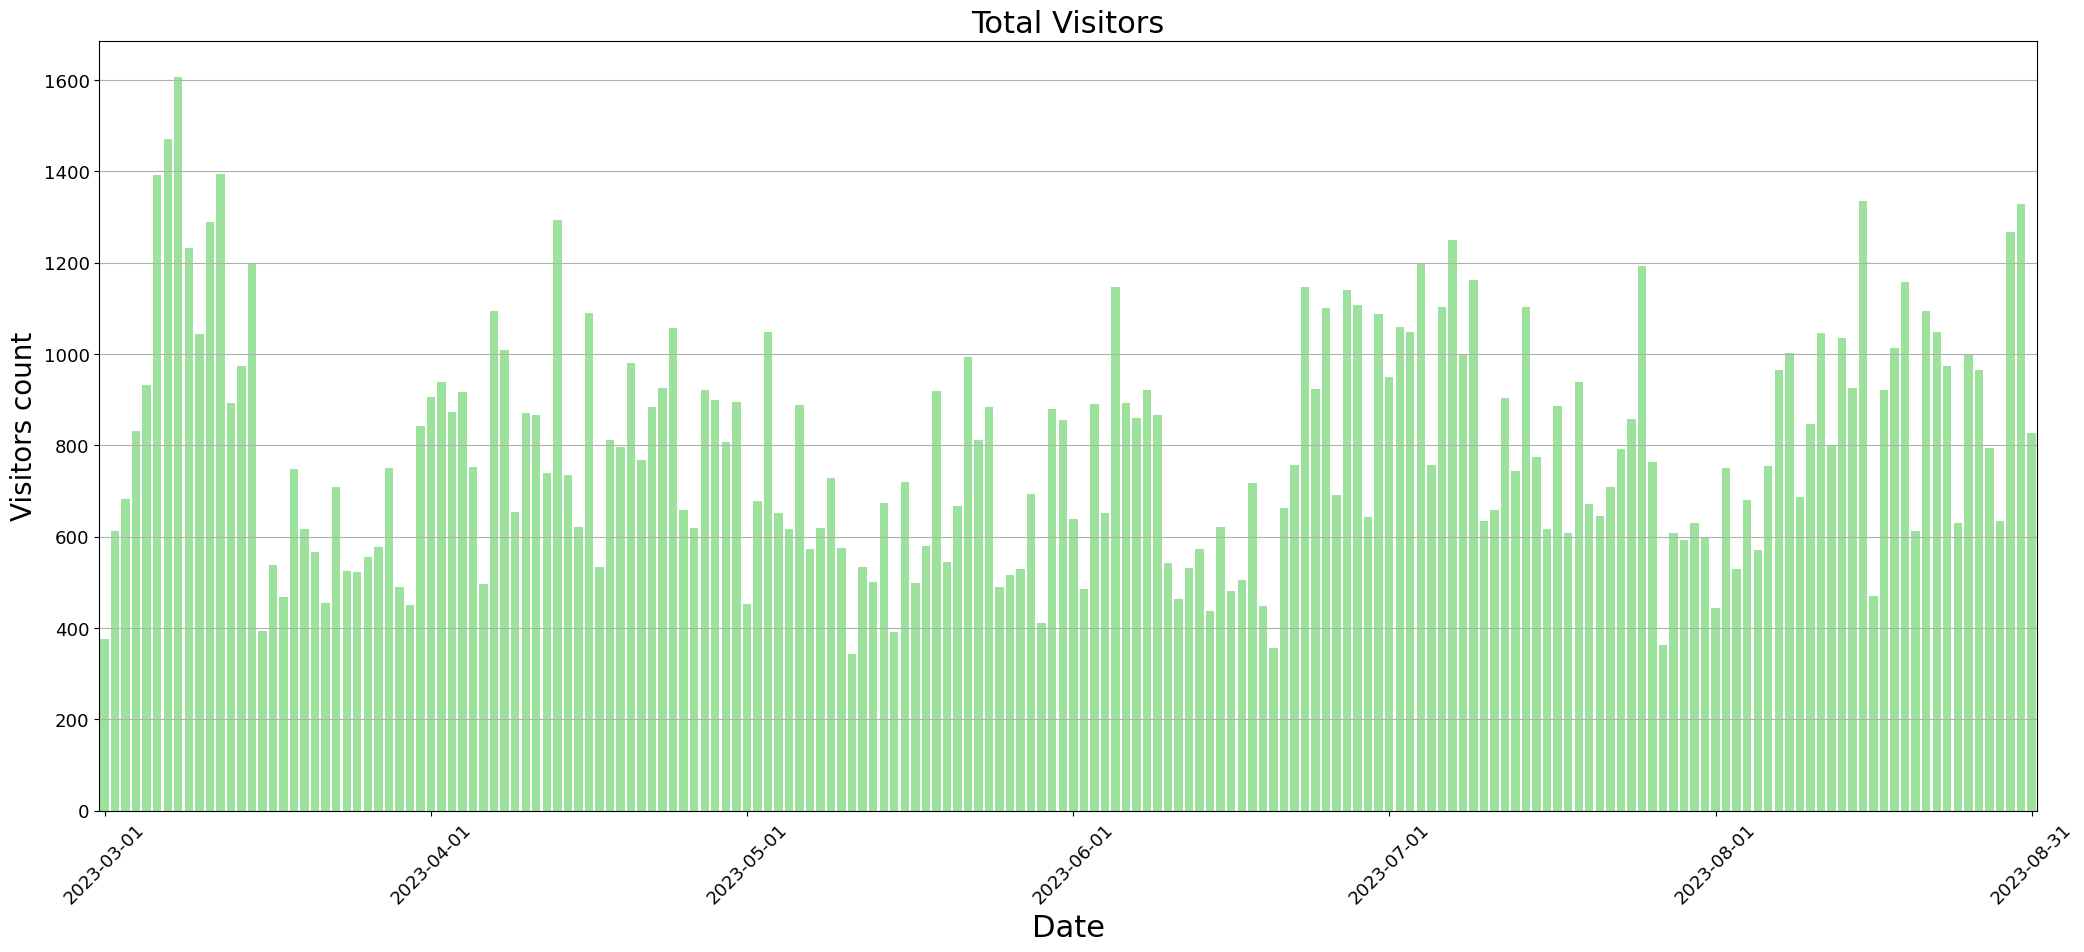

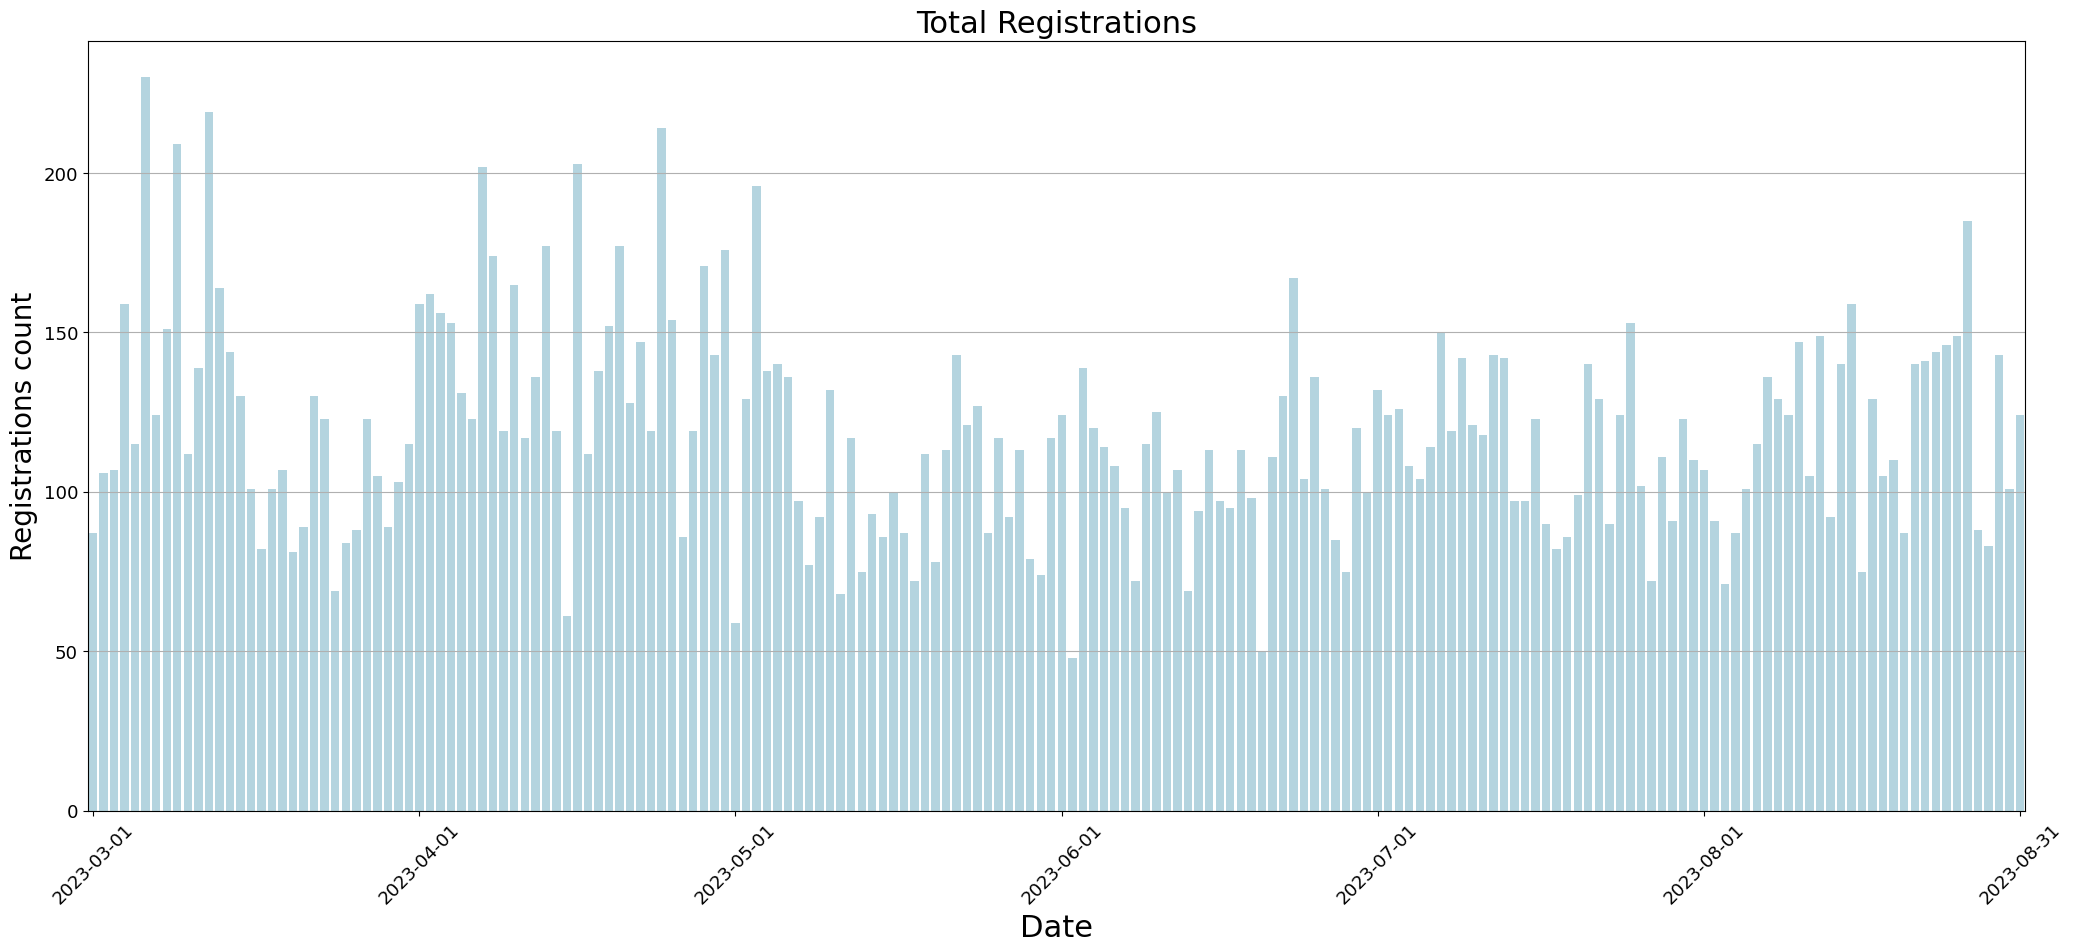

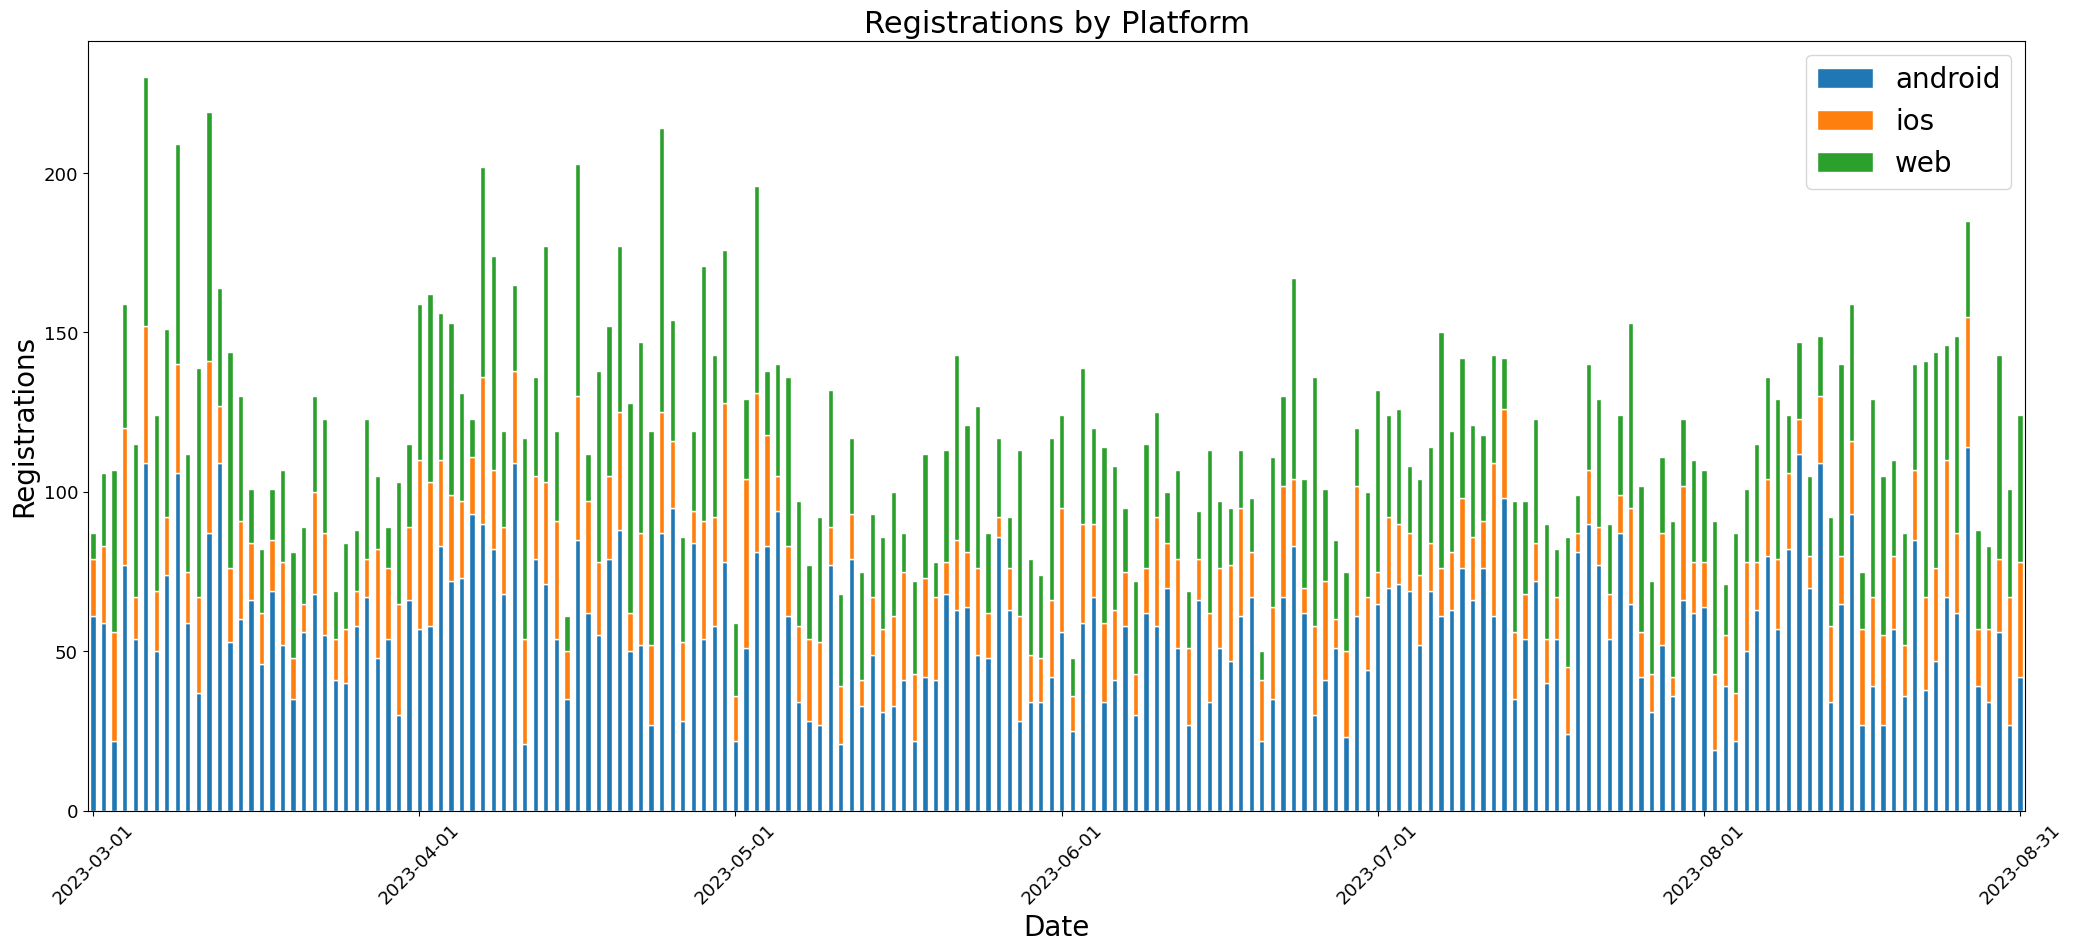

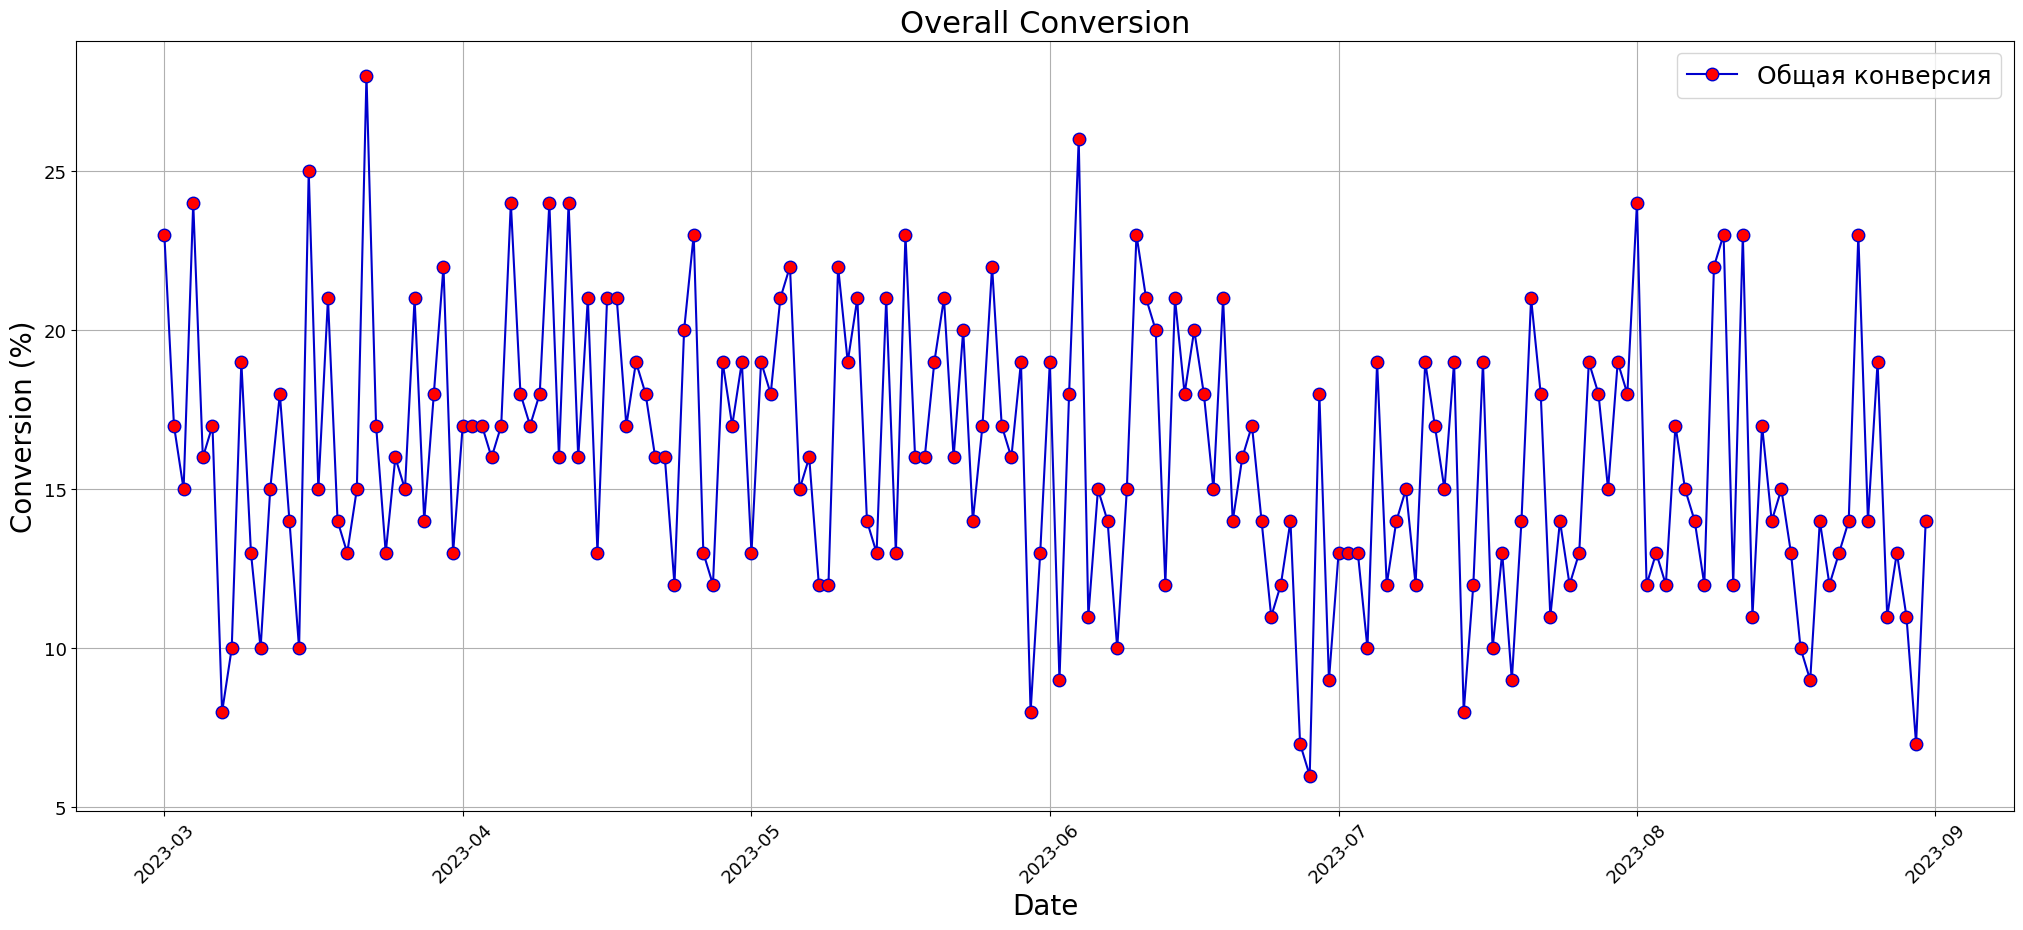

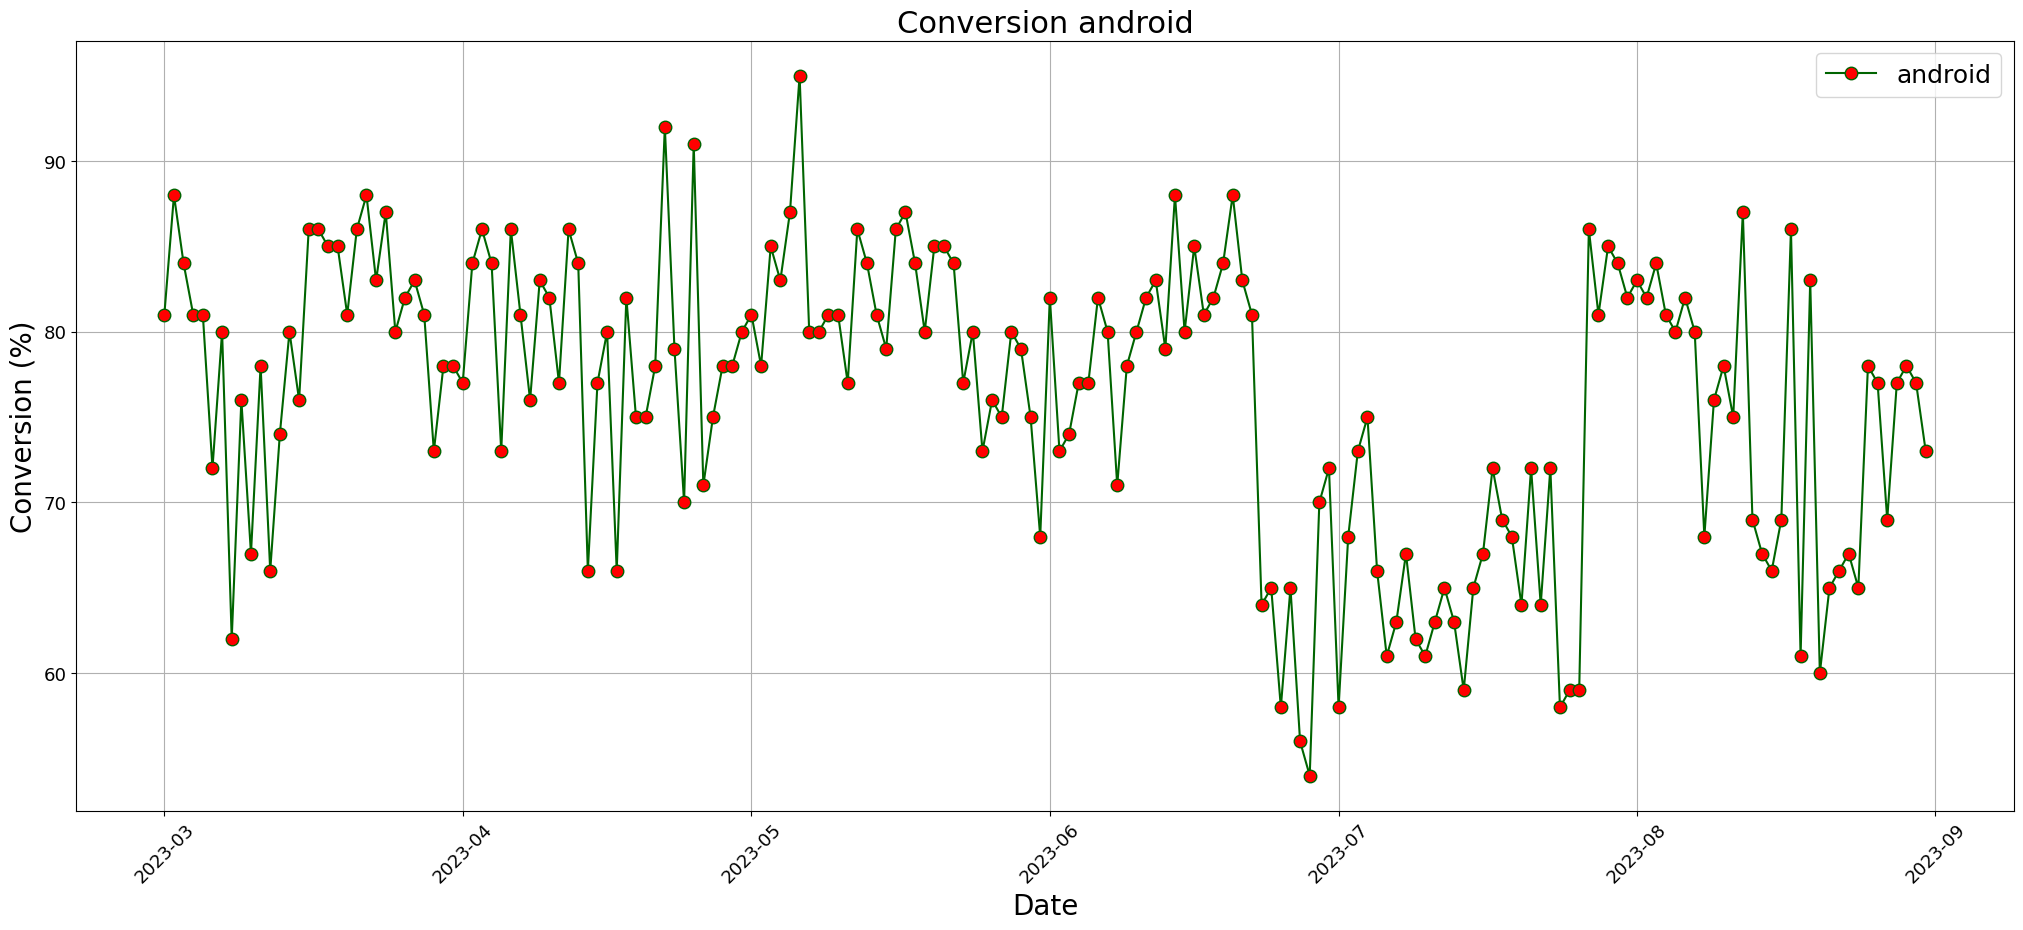

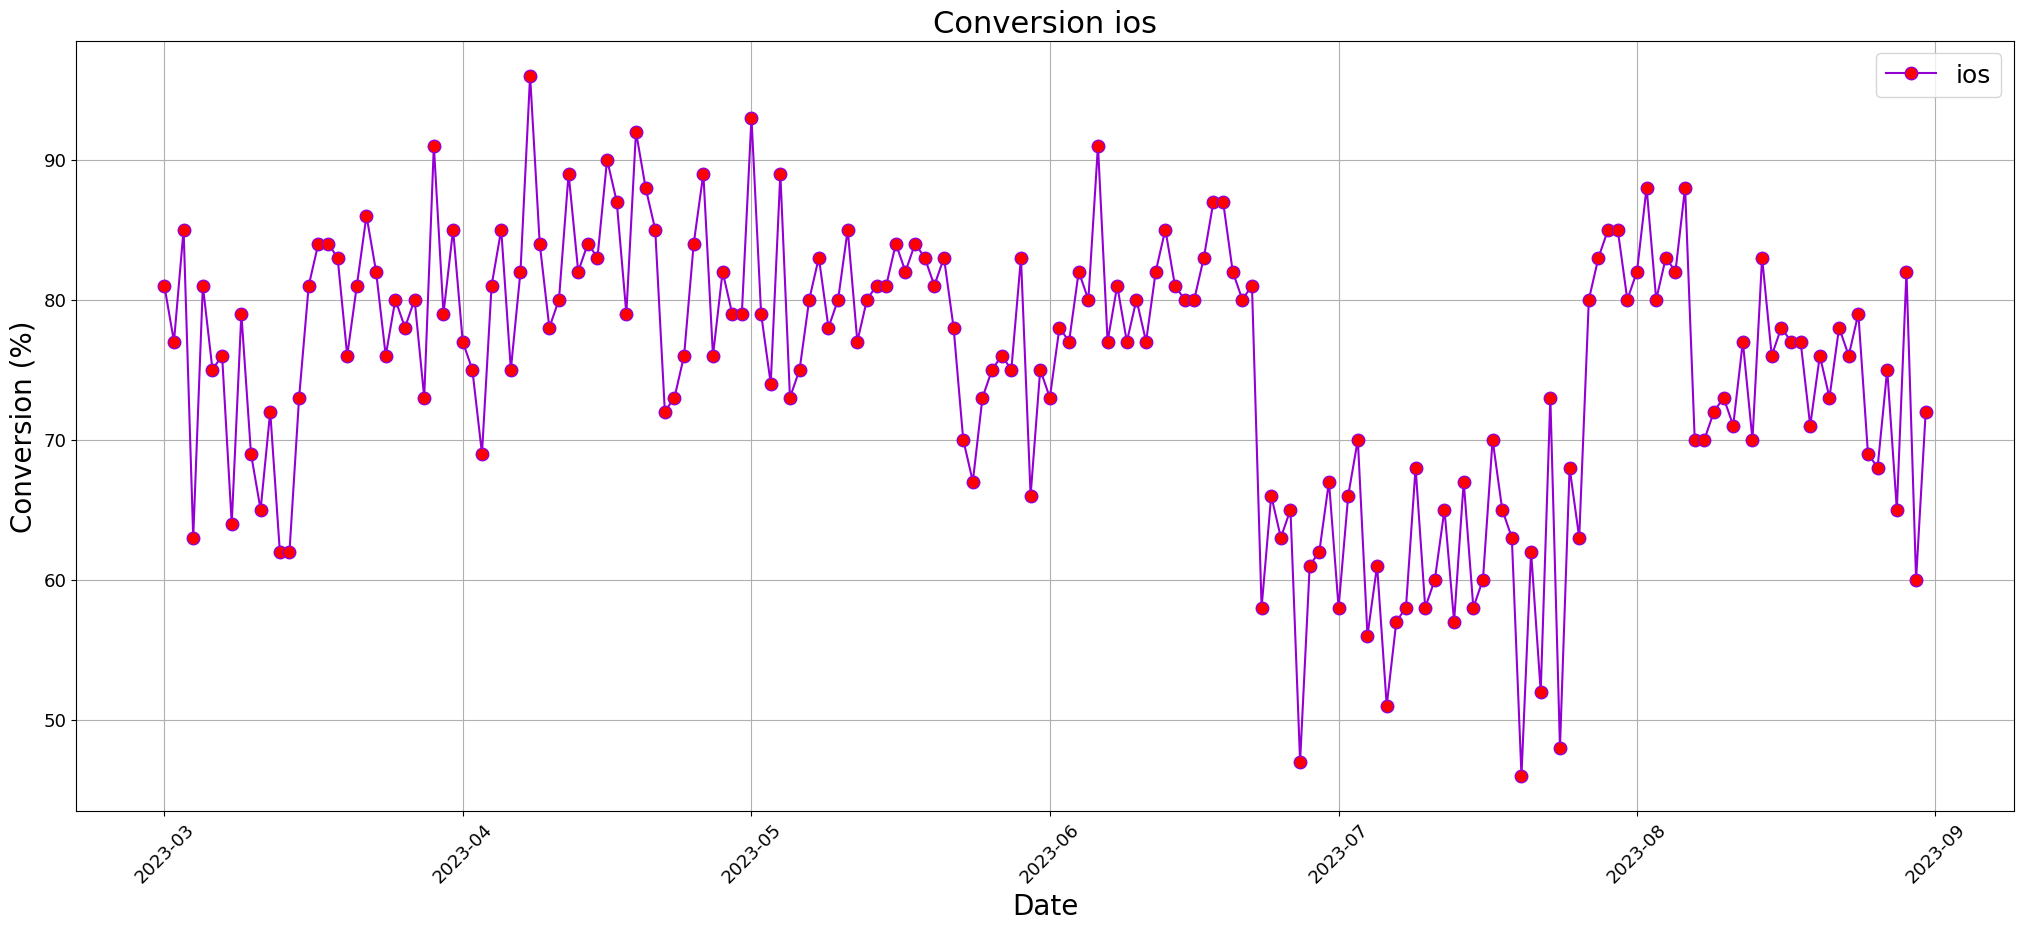

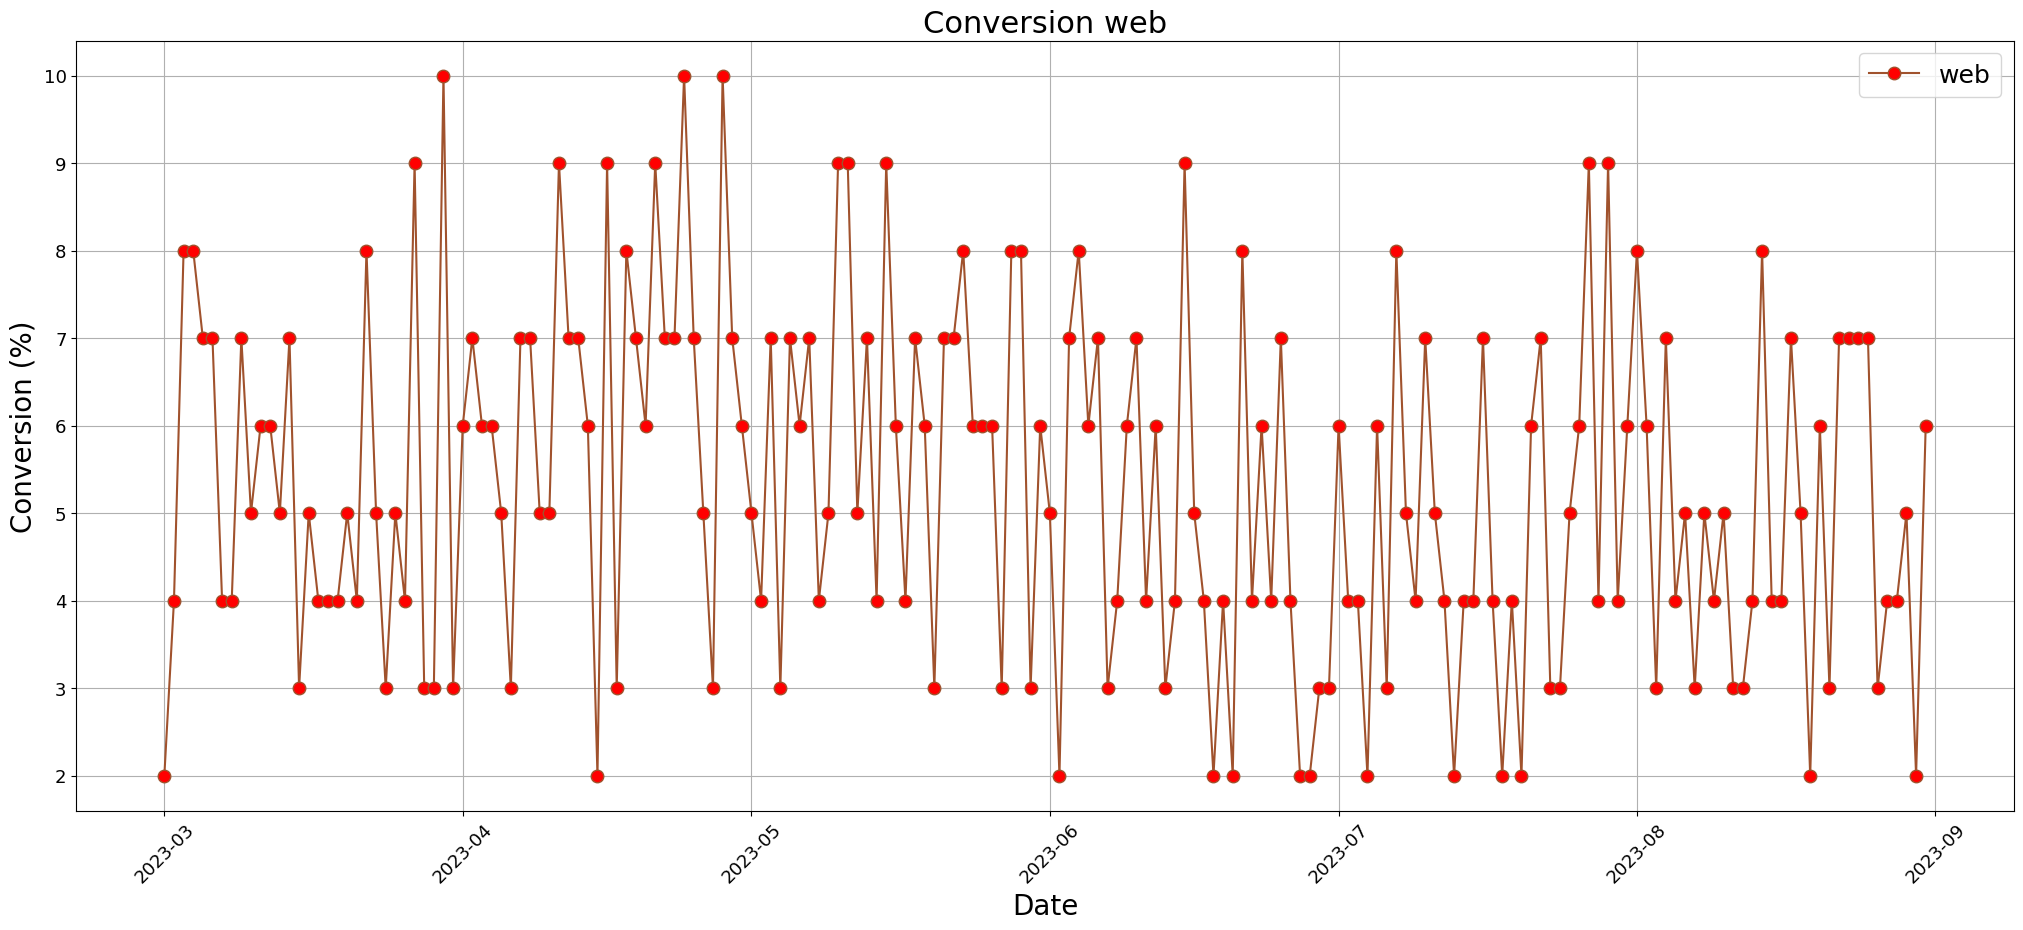

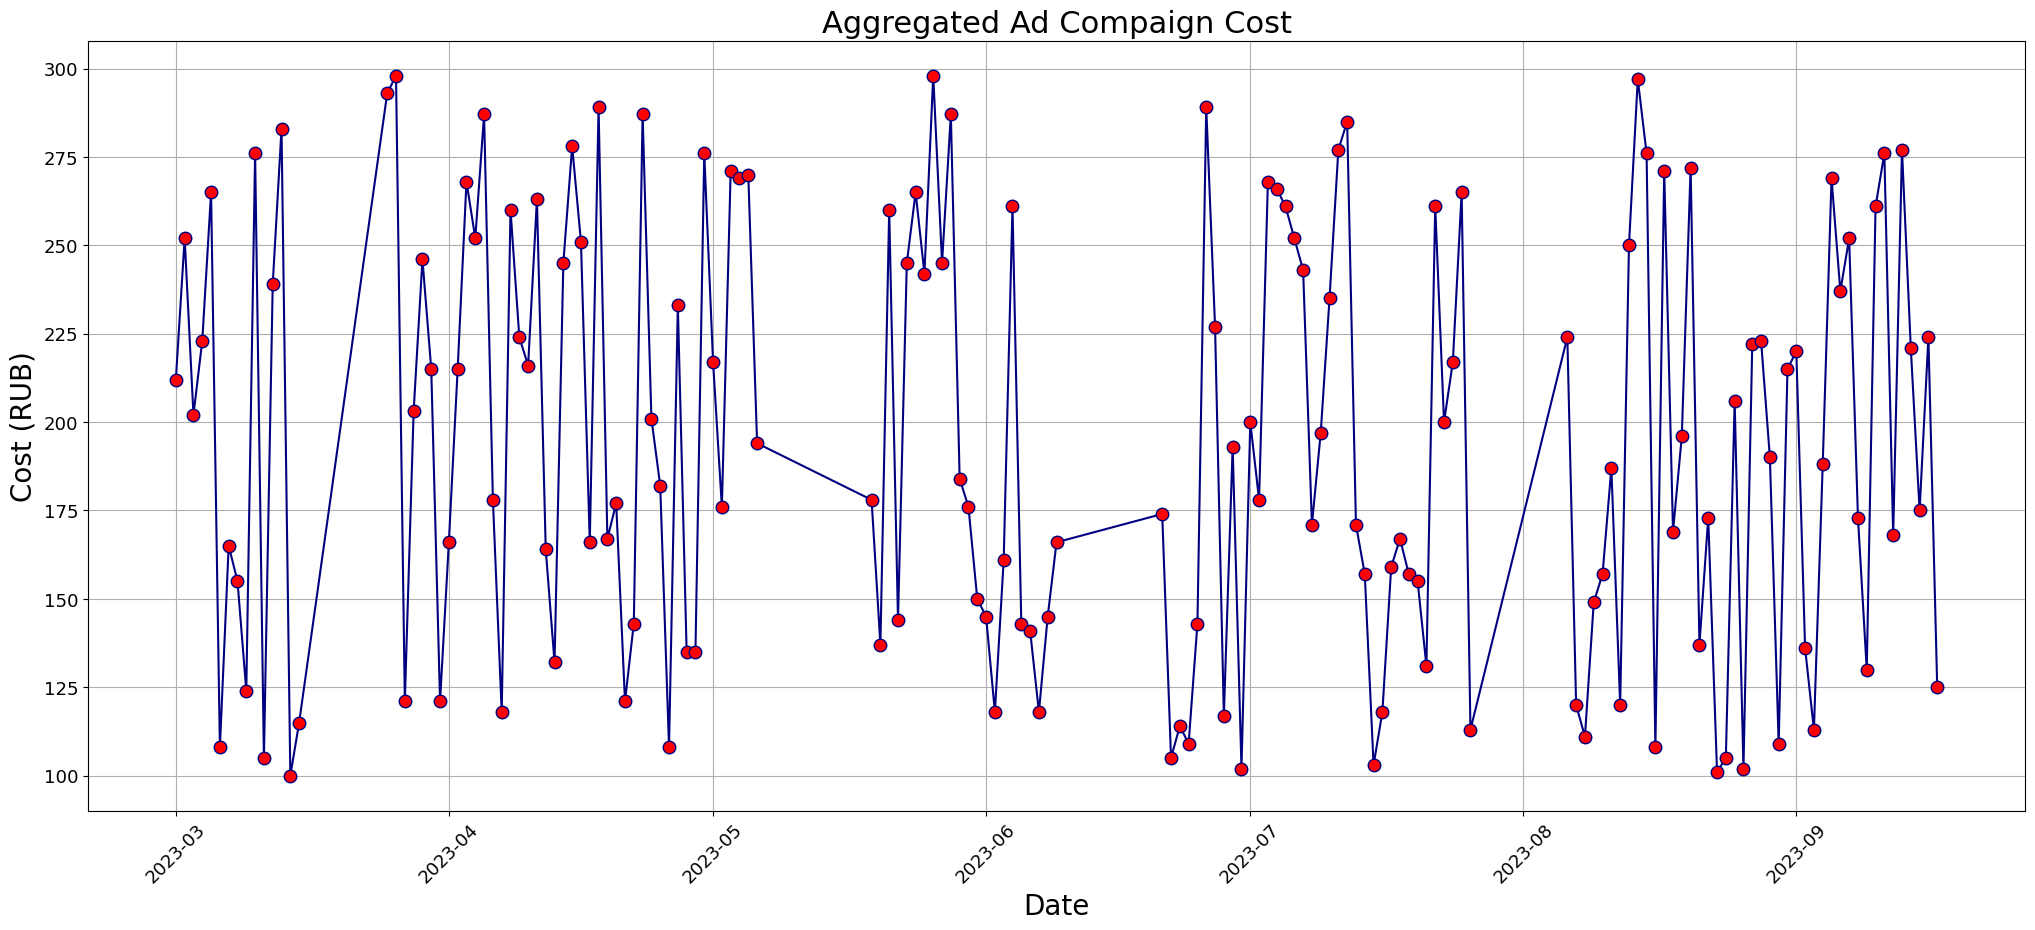

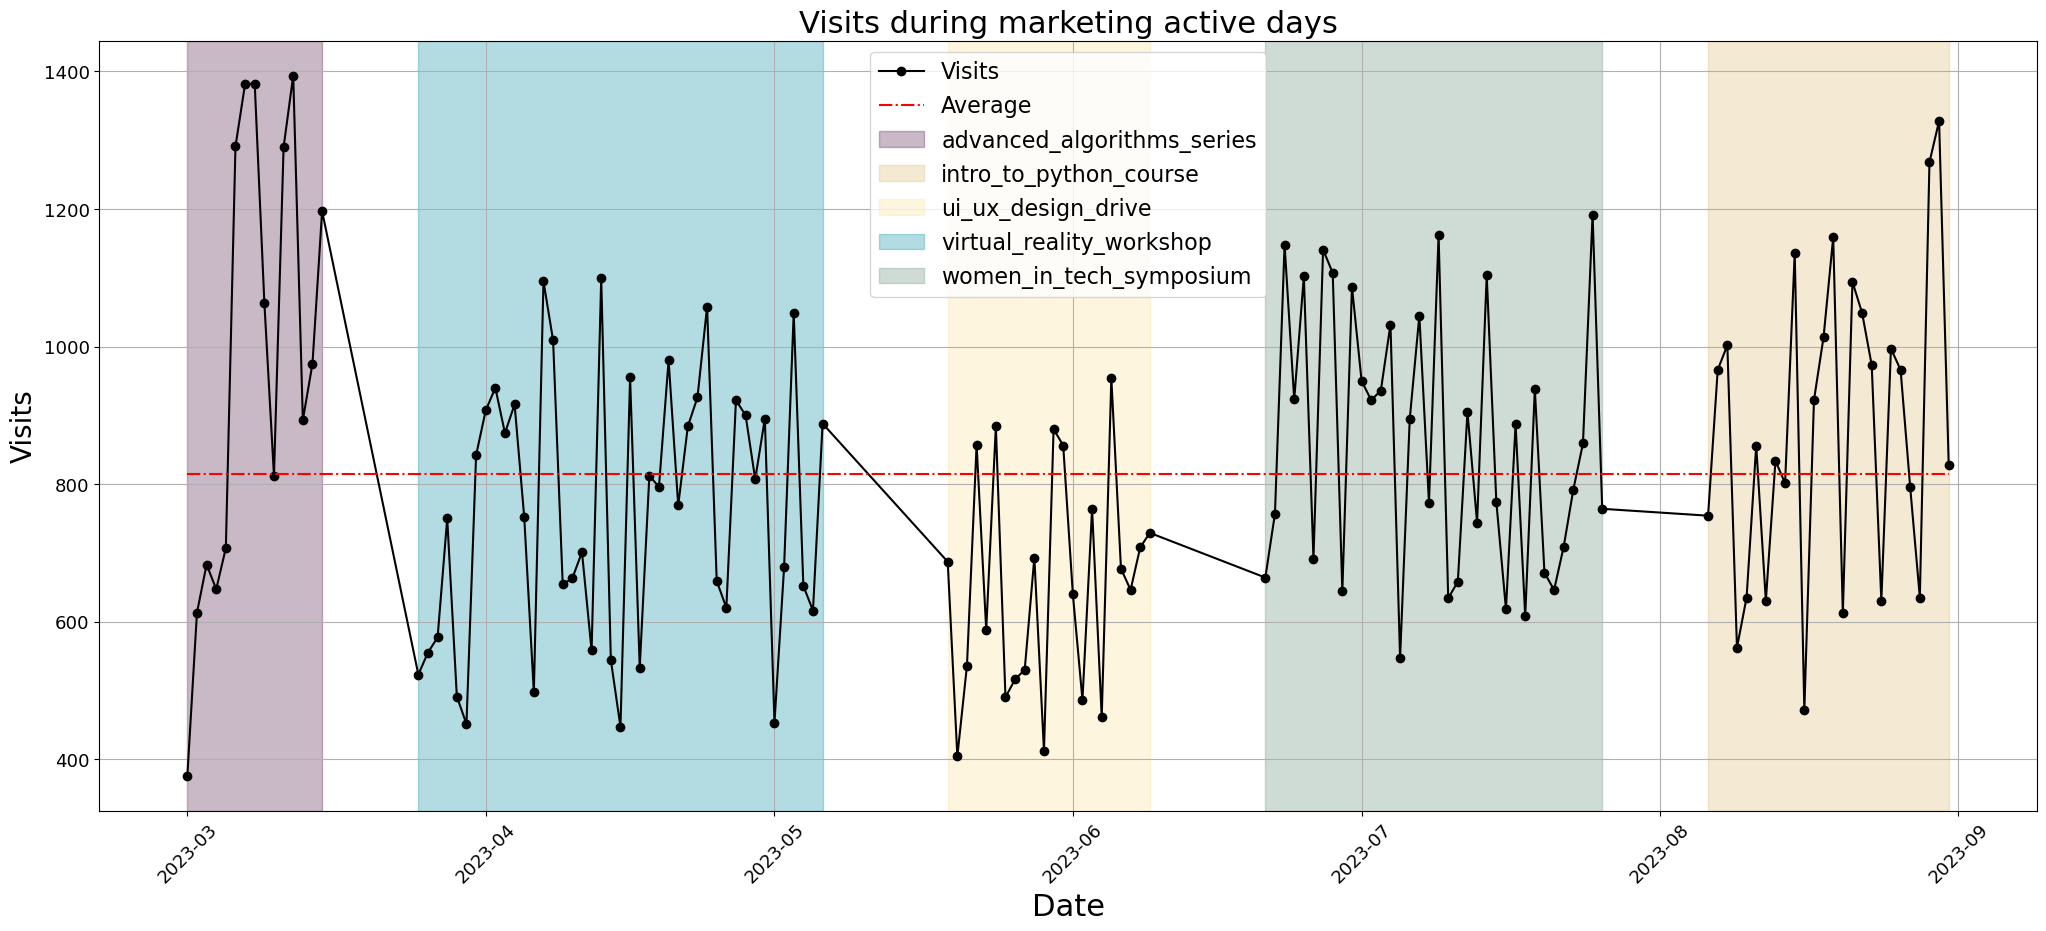

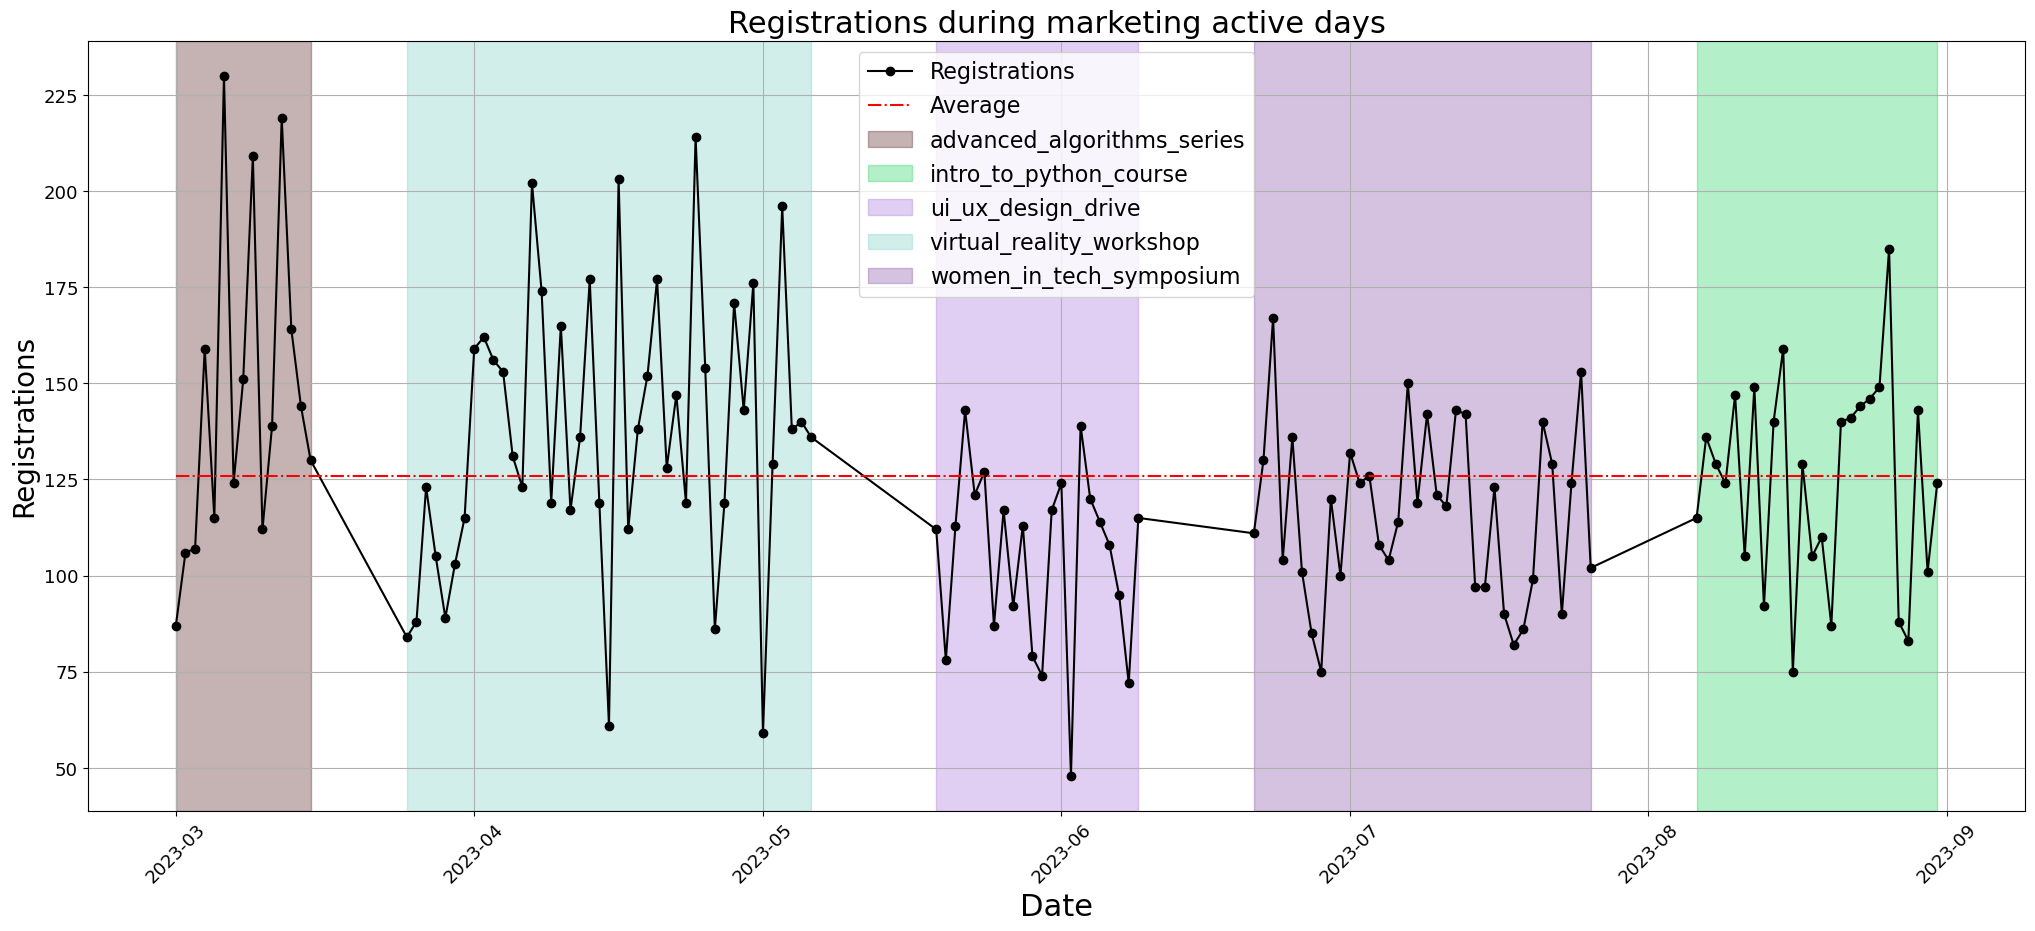

In [140]:
def all_graph():
    visits_agr = visits_ag(visits)
    regs_agr = visits_clean(visits)
    convers = conversion(visits_agr, regs_agr)
    ads = ads_load()
    conv_ads = ads_conv(ads, convers)
    visits_agr = vis_graph(visits_agr)
    regs_agr = reg_graph(regs_agr)
    over_conv = conv_graphs(convers)
    android_conv = android_con(convers)
    ios_conv = ios_con(convers)
    web_conv = web_con(convers)
    ads_graph = ad_graph(ads)
    vis_ads_utm = vis_ad(conv_ads)
    utm = utms(vis_ads_utm)
    reg_ads_utm = reg_ad(conv_ads)

    graph(visits_agr, 'date_group', 'visits', 'lightgreen', 'Date', 'Visitors count', 'Total Visitors', './charts/visits_by_date.png')
    #stack_graph('date_group', 'visits', 'Date', 'Visits', 'Visits by Platform', './charts/visits_by_platform.png')
    graph(regs_agr, 'date_group', 'registrations', 'lightblue', 'Date', 'Registrations count', 'Total Registrations', './charts/registrations_by_date.png')
    stack_graph('date_group', 'registrations', 'Date', 'Registrations', 'Registrations by Platform', './charts/registrations_by_platform.png')
    conv_graph('date_group', 'conversion', over_conv, 'mediumblue', 'Общая конверсия',
               'Date', 'Conversion (%)', 'Overall Conversion', './charts/overall_conversion.png')
    plat_conv_graph('date_group', 'conversion', android_conv, 'darkgreen', 'android',
                    'Date', 'Conversion (%)', 'Conversion android', './charts/android_conversion.png')
    plat_conv_graph('date_group', 'conversion', ios_conv, 'darkviolet', 'ios',
                    'Date', 'Conversion (%)', 'Conversion ios', './charts/ios_conversion.png')
    plat_conv_graph('date_group', 'conversion', web_conv, 'sienna', 'web',
                    'Date', 'Conversion (%)', 'Conversion web', './charts/web_conversion.png')
    ads_graphs(ads_graph)
    market_graph(vis_ads_utm, 'date_group', 'visits', 'Visits', 'Date', 'Visits', 
                 'Visits during marketing active days', './charts/visits_during_marketing.png')
    market_graph(reg_ads_utm, 'date_group', 'registrations', 'Registrations', 'Date', 'Registrations', 
                 'Registrations during marketing active days', './charts/registrations_during_marketing.png')

if __name__ == "__main__":
    all_graph()